In [22]:
#Import libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.formula.api as smf
from statsmodels.othermod.betareg import BetaModel
from statsmodels.genmod import families
links = families.links

# Question of Interest

For LGD data, there are often a lot of 0% values and then a number of non-zero fractions.
For modeling this data, 2 commonly suggested techniques are Zero/One Inflated Beta Regression and Beta Regression with squished endpoints (e.g., 0 -> 0.00001).

This analysis compares the two methods under a scenario where we know the ground truth of effects on LGD.

This analysis assumes that LGDs are either zero or non-zero (and non-one) based on draws from a binomial distribution with probability (1-prob_zero). There is 1 covariate (X) that has a protective effect on LGD. For each 1 unit increase in X, there is a protective effect defined by covariate_effect (e.g., 1/12). 

The question is which method does the best job at identifying the effect under three scenarios:
1. X has no effect on the probability of 0% or non-0% LGD
2. X has the same protective effect and increases the probability that a unit has 0% LGD.
3. X has the opposite effect on whether a unit has a 0% LGD and increases the probability that LGD is > 0%.



In [58]:
#Step 1: Simulate fractional data with heavy right skew and known covariate effects
#There is likely a quicker way to simulate this, but part of the motivation for this project is to learn more python
#Parameters
sample_size = 100
prob_zero = 0.35 #This is on average the proportion of values with 0
covariate_effect = -1/12 #X has a protective effect on LGD. For each unit of X, the LGD


#Define probability of exactly 0% value using binomial distribution
sample = np.random.binomial(n = 1, p = 1-prob_zero, size = sample_size)

#For non-zero entries, replace value with random draw from beta distribution
non_zero_n = len(sample > 0)
non_zero_sample = np.random.beta(a = 5, b = 10, size = non_zero_n)


#Modify the non-zero sample by the X coefficient
X = np.random.normal(loc = 0, scale = 1, size = non_zero_n)
non_zero_sample = non_zero_sample + covariate_effect*X

sample = np.where(sample > 0
                ,non_zero_sample
                , sample)
#Set any values that are < 0% LGD to 0% LGD and > 100% LGD to 100%.
sample = np.where(sample < 0, 0, sample)
sample = np.where(sample > 1, 1, sample)



<Axes: ylabel='Count'>

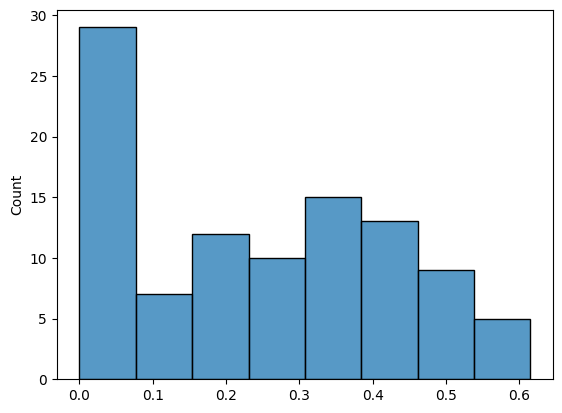

In [59]:
sns.histplot(sample)

This plot shows the skewed distribution, where there are a lot of 0% observations.

The next plot shows the distribution of covariate (X) values used to modify the effect.

<Axes: ylabel='Count'>

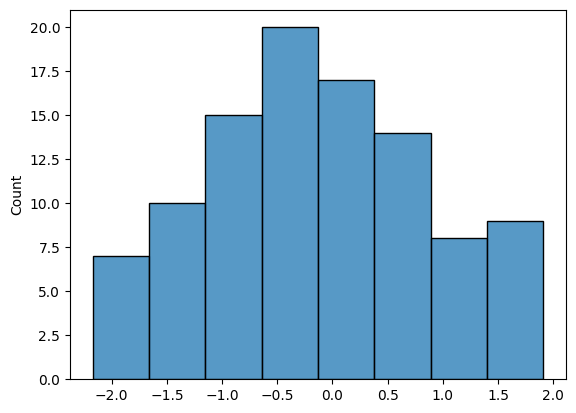

In [60]:
sns.histplot(X)

In [61]:
#Scenario 1 Analysis
sample_df = pd.DataFrame({'lgd': sample,
                          'X': X,
                          'is_zero': np.where(sample == 0, 1, 0)})
#Fit Zero-inflated Beta Regression Model + analyze

logistic_1 = smf.logit('lgd ~ X', data=sample_df).fit()

print('Summary of Pr(lgd = 0) Logistic Regression: ')
print(logistic_1.summary())

beta_sample_df = sample_df[sample_df['lgd'] != 0]
beta_1 = BetaModel.from_formula('lgd ~ X', beta_sample_df).fit()
print('Summary of Beta Regression fit on only 0 < LGD < 1')
print(beta_1.summary())


#Modify zero and 1 values to fit with just beta regression + analyze
beta_squish_df = sample_df.copy()
beta_squish_df['lgd'] = np.where(beta_squish_df['lgd'] == 0, 0.0000001, beta_squish_df['lgd'])
beta_squish_1 = BetaModel.from_formula('lgd ~ X', beta_squish_df).fit()
print('Summary of Beta Regression using Squished LGD Data')
print(beta_squish_1.summary())

Optimization terminated successfully.
         Current function value: 0.439977
         Iterations 5
Summary of Pr(lgd = 0) Logistic Regression: 
                           Logit Regression Results                           
Dep. Variable:                    lgd   No. Observations:                  100
Model:                          Logit   Df Residuals:                       98
Method:                           MLE   Df Model:                            1
Date:                Sat, 03 Jan 2026   Pseudo R-squ.:                  -1.396
Time:                        16:16:40   Log-Likelihood:                -43.998
converged:                       True   LL-Null:                       -18.366
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.2472      0.250     -4.981      0.000      -1.

We know from generating the data that for every 1 unit increase in X, there is a corresponding decrease of 1/12*X in LGD. Additionally, if the decrease in LGD based on the simulated X data were to bring the LGD below 0, the LGD is floored at 0. This could also create an effect on the Pr(LGD = 0).

For this analysis, we are just looking at the impact on the non-zero LGDs. To do this, we will calculate the Average Marginal Effect (AME) estimated by the Beta Regressions.

In [62]:
#Calculate Average Marginal Effect

print("The true AME is", covariate_effect)

#Predict probabilities using the model
beta_1_probs = beta_1.predict(beta_sample_df)
#Store coefficient from model
beta_1_X = beta_1.params.iloc[1]

#Calculate the marginal effect for each row in the sample (X is continuous)
beta_1_marginals = beta_1_X * beta_1_probs/(1-beta_1_probs)
beta_1_ame = np.mean(beta_1_marginals)

print("The AME estimated on 0 < LGD < 1 is:", beta_1_ame)
print("The p-value associated with the coefficient was:", beta_1.pvalues.iloc[1])

#Predict probabilities using the model
beta_squish_1_probs = beta_1.predict(beta_squish_df)
#Store coefficient from model
beta_squish_1_X = beta_squish_1.params.iloc[1]

#Calculate the marginal effect for each row in the sample (X is continuous)
beta_squish_1_marginals = beta_squish_1_X * beta_squish_1_probs/(1-beta_squish_1_probs)
beta_squish_1_ame = np.mean(beta_squish_1_marginals)

print("The AME estimated on Squished LGD Data is:", beta_squish_1_ame)
print("The p-value associated with the coefficient was:", beta_squish_1.pvalues.iloc[1])


The true AME is -0.08333333333333333
The AME estimated on 0 < LGD < 1 is: -0.22407075057803352
The p-value associated with the coefficient was: 9.090221725158613e-13
The AME estimated on Squished LGD Data is: -0.08417647275911241
The p-value associated with the coefficient was: 0.13162801565639604


The coefficient estimate for both models is accurately less than 0, but the magnitudes are different. The model on just data with 0 < LGD < 1 has a larger coefficient than the simulated truth. The model on squished data has a coefficient that is generally lower than the true AME, but on the sample with n = 100 was fairly close (-0.084 vs. -0.083).

The 0 < LGD < 1 regression generally has a statistically significant coefficient, but the squished data coefficient is often not significant. 

In [63]:
#Scenario 2 Analysis

#Resample data
#Fit models and re-analyze

In [ ]:
#Scenario 3 Analysis

#Resample data
#Fit models and re-analyze